In [120]:
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [121]:
import numpy as np
import numpy as np
import csv
import requests
from contextlib import closing
import csv
from codecs import iterdecode

from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

In [122]:

file = open("FTSE100.tickers")
iter = csv.reader(file, delimiter='\n')
tickers = []
for ticker in iter:
    tickers=tickers+[ticker[0].split(".")[0]]

<Axes: >

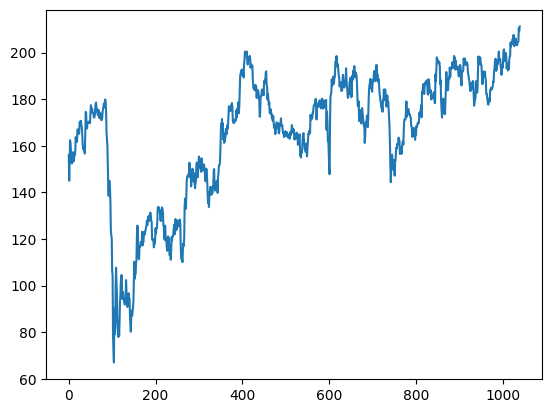

In [123]:
import pandas as pd

stocks = {}

for tick in tickers:
    stocks[tick] = pd.read_csv(f"HistoricPrices/{tick}.csv", header = 0, names=("Day", "Price"))

stocks["MNG"]["Price"].plot()

In [124]:
stocks["BP"].diff()

,Day,Price
0,NaN,NaN
1,1.0,-7.566803
2,1.0,-17.933441
3,1.0,8.701843
4,1.0,-4.313080
...,...,...
1256,1.0,-1.450012
1257,1.0,-0.049988
1258,1.0,-3.049988
1259,1.0,7.149994


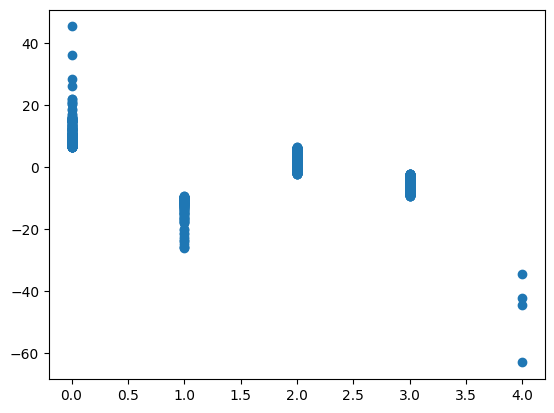

In [125]:
data = stocks["BP"].diff().dropna()["Price"].to_numpy()[1:]
clust = AgglomerativeClustering(5)
clust.fit(data.reshape(-1, 1))

preds = clust.fit_predict(data.reshape(-1, 1))

plt.scatter(preds, data)


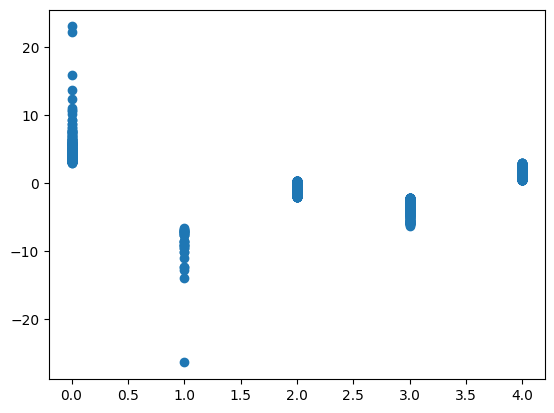

In [126]:
data = stocks["MNG"].diff().dropna()["Price"].to_numpy()[1:]
clust = AgglomerativeClustering(5,linkage="ward")
clust.fit(data.reshape(-1, 1))

preds = clust.fit_predict(data.reshape(-1, 1))

plt.scatter(preds, data)


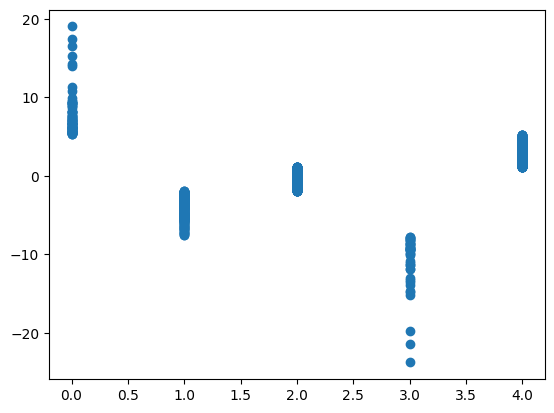

In [127]:
data = stocks["NWG"].diff().dropna()["Price"].to_numpy()[1:]
clust = AgglomerativeClustering(5,linkage="ward")
clust.fit(data.reshape(-1, 1))

preds = clust.fit_predict(data.reshape(-1, 1))

plt.scatter(preds, data)


In [128]:
def estimateClassProbsFromSample(preds,classes):
    probs = []
    for i in range(classes):
        probs.append(np.count_nonzero(preds == float(i))/len(preds))
    return probs

#Use the mean element as a representitive of the cluster (could have also have used the median)
def calculateCentralClassElement(x, preds, classes):
    sizes = {x:0 for x in range(classes)}
    cumulative = {x:0 for x in range(classes)}
    for i in range(len(x)):
        assignedClass = int(preds[i])
        sizes[assignedClass] += 1
        cumulative[assignedClass] += x[i]
    return [cumulative[i]/sizes[i] for i in range(classes)]

In [129]:
classes = 5
meanJumps = calculateCentralClassElement(data,preds,classes)
jumpProbs = estimateClassProbsFromSample(preds,classes)


In [130]:
#Import the finite market model functionality from the PortfolioBase notebook
%pip install nbformat
%run PortfolioBase.ipynb

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [135]:
def naiveFitMultinomialStock(stocksData, ticker : str, classes : int, linkage = "ward"):

    data = stocks[ticker].diff().dropna()["Price"].to_numpy()[1:]

    clust = AgglomerativeClustering(classes ,linkage=linkage)
    clust.fit(data.reshape(-1, 1))
    
    preds = clust.fit_predict(data.reshape(-1, 1))

    meanJumps = calculateCentralClassElement(data,preds,classes)
    jumpProbs = estimateClassProbsFromSample(preds,classes)

    initial = stocksData[ticker].dropna()["Price"][1]
    model = MultinomialStock(f"{ticker} {str(classes)}-jump",initial,meanJumps, jumpProbs)
    return model

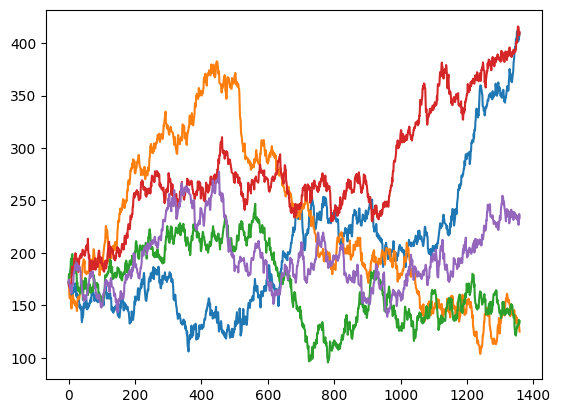

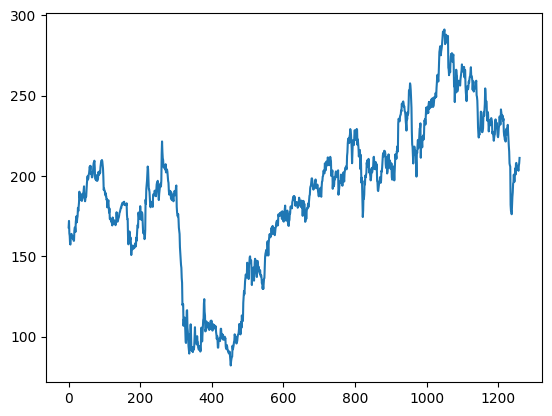

In [136]:
initial = stocks["NWG"].dropna()["Price"][1]
natWest = MultinomialStock("NWG 5-jump",initial,meanJumps, jumpProbs)
runs = []
for h in range(5):
    values = []
    for i in range(len(data)+100):
        values.append(natWest.value)
        natWest.evolve()
    natWest.reset()
    runs.append(values)

for values in runs:
    plt.plot(values)
plt.show()
plt.plot(stocks["NWG"]["Price"])

In [139]:
for tick in tickers:
    naiveFitMultinomialStock(stocks, tick, 6)